### Multi-layer perceptrons for classification and regression problems.

<center><h1 style="font-size:40px;">Classification</h1></center>

Welcome to the second lab in the Deep learning course! In this lab we will continue to take a look at four parts for MLP classification;
* Introduction for setup and train an MLP
* Impact of overfitting in validation performance 
* Avoid overfitting for a regression problem
* Model selection for classification



The lab includes different datasets, binary and multiple classification problems, and function approximation problems. 
The first part of the lab uses three different synthetic classification problems. They are all 2D binary classification problems that allow for easy visual inspection of the other classes and the network decision boundary. The datasets are defined as *syn1, syn2*, and *syn3*. These datasets are generated "on the fly" each time and are sampled from normal distributions. Note that as the data is sampled from a distribution, the data will vary for each time the data is generated it will be slightly different.

All tasks include **TODO's** these are expected to be done before the deadline for this lab. The labs also include **Question**, which should be answered and included in the report. The lab gives a hand to ensure correct answer with a few asserts or the expected results. Some sections do not contain any **TODO's** but are good to understand.

Good luck!

---

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MLPData:
    """
    This class will manage all the dataset related functions for this lab.
    Please take the time do go through the code and try to understand how each point is generated
    """
    @staticmethod
    def syn1(N):
        """data(samples, features)

        :param N: Number of DataPoints

        """
        data = np.empty(shape=(N,2), dtype = np.float32)  
        tar = np.empty(shape=(N,), dtype = np.float32) 
        N1 = int(N/2)

        data[:N1,0] = 4 + np.random.normal(loc=.0, scale=1., size=(N1))
        data[N1:,0] = -4 + np.random.normal(loc=.0, scale=1., size=(N-N1))
        data[:,1] = 10*np.random.normal(loc=.0, scale=1., size=(N))


        data = data / data.std(axis=0)

        # Target
        tar[:N1] = np.ones(shape=(N1,))
        tar[N1:] = np.zeros(shape=(N-N1,))

        # Rotation
        theta = np.radians(30)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c,-s],[s,c]]) # rotation matrix
        data = np.dot(data,R) 

        return data,tar
    
    @staticmethod
    def syn2(N):
        """data(samples, features)

        :param N: 

        """

        data = np.empty(shape=(N,2), dtype = np.float32)  
        tar = np.empty(shape=(N,), dtype = np.float32) 
        N1 = int(N/2)

        # Positive samples
        data[:N1,:] = 0.8 + np.random.normal(loc=.0, scale=1., size=(N1,2))
        # Negative samples 
        data[N1:,:] = -.8 + np.random.normal(loc=.0, scale=1., size=(N-N1,2))


        # Target
        tar[:N1] = np.ones(shape=(N1,))
        tar[N1:] = np.zeros(shape=(N-N1,))

        return data,tar

    @staticmethod
    def syn3(N):
        """data(samples, features)

        :param N: 

        """
        data = np.empty(shape=(N,2), dtype = np.float32)  
        tar = np.empty(shape=(N,), dtype = np.float32) 
        N1 = int(2*N/3)

        # disk
        teta_d = np.random.uniform(0, 2*np.pi, N1)
        inner, outer = 2, 5
        r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N1))
        data[:N1,0],data[:N1,1] = r2*np.cos(teta_d), r2*np.sin(teta_d)

        #circle
        teta_c = np.random.uniform(0, 2*np.pi, N-N1)
        inner, outer = 0, 3
        r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N-N1))
        data[N1:,0],data[N1:,1] = r2*np.cos(teta_c), r2*np.sin(teta_c)

        # Normalization
        #data = data - data.mean(axis=0)/data.std(axis=0)

        tar[:N1] = np.ones(shape=(N1,))
        tar[N1:] = np.zeros(shape=(N-N1,))

        return data, tar
    
    @staticmethod
    def spiral(spiral_path):
        """

        :param spiral_path: 

        """
        tmp = np.loadtxt(spiral_path)
        data, tar = tmp[:, :2], tmp[:, 2]

        return data, tar
    
    @staticmethod
    def regr1(N, v=0):
        """data(samples, features)

        :param N: param v:  (Default value = 0)
        :param v: Default value = 0)

        """
        data = np.empty(shape=(N,2), dtype = np.float64)  

        uni = lambda n : np.random.uniform(0,1,n)
        norm = lambda n : np.random.normal(0,1,n)
        noise =  lambda  n : np.random.normal(0,1,n)
        data[:,0] = norm(N)
        data[:,1] = uni(N)
            

        tar =   10*data[:,0] + np.sin(20*np.pi * data[:,1])
        std_signal = np.std(tar)
        tar = tar + v * std_signal * noise(N)

        return data, tar


Do not forget to instanciate an object of the above class for you to be able to generate dataset on the fly!

In [3]:
datasets = MLPData()

Let's see how each dataset looks like! 

In [4]:
def data_distribution(imgs, shape=(2,2)):
    """Plot scatter distribution for a list of images.
    """
    f, axs = plt.subplots(*shape, figsize=(10,10))
    axs = axs.flatten()
    
    if isinstance(imgs,list):
        for idx, ((d,t), ax) in enumerate(zip(imgs, axs)):
            ax.scatter(d[:,0],d[:,1], c=t)
            ax.set_title(f"Plot number: {idx}")
    elif isinstance(imgs,dict):
        for (key, (d,t)), ax in zip(imgs.items(), axs):
            ax.scatter(d[:,0],d[:,1], c=t)
            ax.set_title(key)
    plt.show()

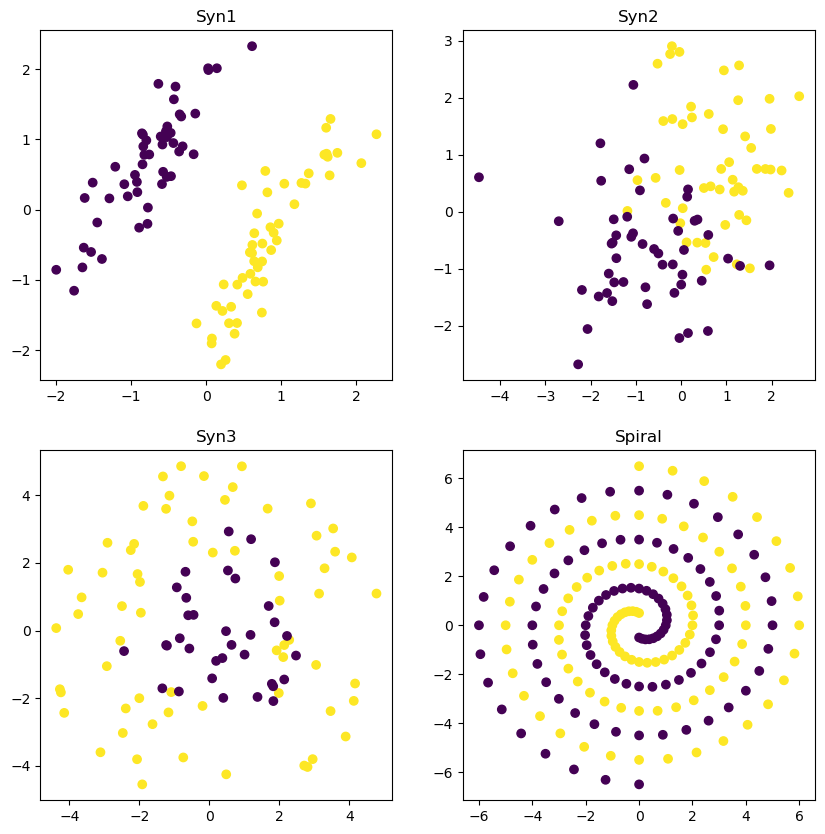

In [5]:
data_distribution({
    "Syn1":MLPData.syn1(100),
    "Syn2":MLPData.syn2(100),
    "Syn3":MLPData.syn3(100),
    "Spiral":MLPData.spiral('../data/lab2/spiral.dat'), #the dataset spiral is saved on a file. You can actually open it to check what's inside. If you had to guess what does each column represent?
})

Let's define a very easy and straight forward model. It consists of only two Linear layers: The input layer and the output layer.
You need to fill in the corresponding ```ìn_dimension``` and ```out_dimension``` when instancianting the class. 

In [6]:
class NeuralNet(torch.nn.Module):
    def __init__(self, 
                in_dimension=None,         
                hidden_nodes=1,                     
                out_dimension=None,
            ):
        super(NeuralNet, self).__init__()
        self.fc1 = torch.nn.Linear(in_dimension, hidden_nodes)
        self.relu = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(hidden_nodes, out_dimension)
        
        


    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        
        return torch.sigmoid(output)
    
    def predict(self,x):
        pred = self.forward(x)
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t>0.5:
                ans.append(1)
            else:
                ans.append(0)
        return torch.tensor(ans)

We also need to transform the output each dataset coming from ```MLPData``` into a proper ```Pytorch Dataset```.

We will need to import extra functions to help us with that. 
You can find the corresponding documentation [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and [here](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

In [7]:
from torch.utils.data import TensorDataset, DataLoader

Ok let's try to create a ```Pytorch Dataset``` for syn1. You can do the same for the other datasets we are going to use throughout this lab.

In [8]:
x,y = datasets.syn1(100) #let's start with 100 points

The main issue is that ```datasets.syn1(N)``` returns two numpy arrays: one for the data itself, and another for the corresponding labels. But when we train a model in ```Pytorch``` we need to think in terms of tensors (the roughly equivalent of numpy in the ```Pytorch``` world)!

In [9]:
x = torch.Tensor(x) #simply convert each array to a Tensor

To convert our ```y``` we need an extra trick. Think about the dimensions of both ```x``` and ```y```. Is ```y``` following the same structure of ```number of points, dimensionality of the data```? 

In [10]:
y = torch.Tensor(y)
y.shape

torch.Size([100])

An easy way to fix this is by doing the following:

In [11]:
y = torch.Tensor(y).unsqueeze(1)

Now that we actually have tensors, how to make sure of the two functions we import earlier?

In [12]:
syn1_Pytorch = TensorDataset(x,y)

In [13]:
type(syn1_Pytorch)

torch.utils.data.dataset.TensorDataset

```Pytorch``` has several predefined easy to use datasets subclasses. We are using the ```TensorDataset``` in this lab. 

After having our dataset we still need a ```DataLoader``` to be able to iterate throw the data. Remember, a ```Dataset``` is a class that manages the dataset being used, not a way to iterate over your dataset!

In [14]:
loader = DataLoader(syn1_Pytorch, batch_size=2)

# Question 1

Why when we do a ```for loop ``` on the dataset we only get 50 elements? 

In [15]:
for batch_ndx, (xi,yi) in enumerate(loader):
    print(batch_ndx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Given that we are want to perform binary classification, we need to import the ```BCELoss```

In [16]:
from torch.nn import BCELoss

We now need to import our optimizer. You can play with different ones. For a complete list check [here](https://pytorch.org/docs/stable/optim.html#algorithms)! We will be using Adam throughout the following examples, but again you are free to try with different ones. Just be sure to note that on your report!

Pay attention that we do not instanciate the class as we just want a new placeholder named ```optimizer``` to make it easier if you decide to change it in the future!
When creating an instance of ```Adam``` we need to already have an instance of our model to pass in the parameters!

In [17]:
optimizer = torch.optim.Adam
loss = BCELoss()

Now lets try to put it all together to train our first Model!

# Question 2

Finish the below function. The task at this point is to create a function that is able to train your ```model``` for ```epoch_number``` using ```optimizer```, ```loss``` and ```dataloader```

Remember what we said above? ```optimizer``` isn't instanciated. Do not forget to do so inside of your function!

In [18]:
def train(epoch_number,optimizer,loss,model,dataloader):
    #TODO
    opt = optimizer(model.parameters())
    for e in range(epoch_number):
        for batch_idx, (xi,yi) in enumerate(dataloader):
            opt.zero_grad()
            pred = model(xi)
            l = loss(pred,yi)
            l.backward()
            opt.step()
            if (batch_idx % 10) == 0:
                print("\r[Batch {} of Epoch {}]\t Loss:{}".format(batch_idx,e,l),end='')
    

Now that we have a way to trian our model, we need to create an instance of the model and train it. We still need a way to evaluate our model. In this simple datasets, we can try to visualize the decision boundaries. 

We will create one ```helper function```: ```plot_decision_boundary```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch

def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
    color_map = plt.get_cmap(color_map)
    
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

    # Plot decision boundary in region of interest
    labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels_predicted = model(dataset)
    ax.scatter(dataset[:, 0], dataset[:, 1], c=labels.reshape(labels.size()[0]), cmap=color_map, lw=0)
    plt.show()
    model.train()
    return fig, ax

## Question 3

Now the only thing missing to visualize you results is a trained network. Assuming you named your network ```my_model```, this should show your decision boundary

In [ ]:
my_model = #How to instanciate the Model?
train(20,optimizer,loss,my_model,loader)

In [ ]:
plot_decision_boundary(x,y,my_model)

The above cell is giving you a ```qualitative``` way to inspect how good your network is. We also need to have a ```quantitative``` way of doing so. We are going to use another helper function to be able to do so.

In [ ]:
def stats_class(x, y, model):
    """

    :param x:list: The data itself (Default value = None)
    :param y:list: The groundtruth labels (Default value = None)
    :param model:"nn.Module":  (Default value = None)
    
    input :
             x = input
             y = output
             model = the model
    
    output :
             sensitivity = fraction of correctly classified positive cases
             specificity = fraction of correctly classified negative cases
             accuracy = fraction of correctly classified cases
             
    """

    model.eval()
    y_pr = model.predict(x).numpy().reshape(y.shape)

    y = y.numpy()
   
    nof_p, tp, nof_n, tn = [np.count_nonzero(k) for k in [y==1, y_pr[y==1.] > 0.5, y==0, y_pr[y==0.]<= 0.5]]
    
    if nof_p == 0:
        raise ValueError("No False Positive cant be zero")
    
    if nof_n == 0:
        raise ValueError("No False Negative cant be zero")
        
    sens = tp / nof_p 
    spec = tn / nof_n
    acc = (tp + tn) / (len(y))
                
    A = ['Accuracy', 'Sensitivity', 'Specificity']
    B = [acc, sens, spec]#, loss]
    
    print('\n','#'*20,'STATISTICS', '#'*20, '\n')
    for r in zip(A,B):
         print(*r, sep = '   ')
    print('\n','#'*50)

In [ ]:
stats_class(x,y,my_model)

# Question 4

Now that we have everything needed to train, we need to generate more data!

A proper training procedure is divided into ```3 splits```: training, validation and test!

Please create each of the splits with 200 (training), 100 (validation) and 1000 (test) for each of the three synthetic dataset ```syn1, syn2, syn3```.

# Question 5

For the ```syn1``` what is the theoretical minimum number of hidden nodes to have a good classifier? Can you train a model with said number of hidden nodes? How many epochs to get a perfect score? When you compare the statistics with the other two splits, how much does it change? And why do you think that happens? Be sure to use all available statistical information about the performance (i.e. Accuracy, Sensitivity and Specificity on your answer)

# Question 6

If you use the same architecture you found for the question above on ```syn2``` what are the statistics? And how does the decinsion boundary looks like? Did you expect it to perform similar, better or worse? And why?
Do not forget we need both a ```Dataset``` object and a ```Dataloader``` like we did for ```syn1``` in the previous examples!

# Question 7 

Feel free to adapt the number of hidden nodes (and possibly the number of hidden layers and epochs) required to achieve an accuracy of > 95%!

# Question 7.1
Compare your results with the validation and test set. Does the accuracy you got for the training set stays the same on the validation/test set? Analyse the results!

# Question 8


Now lets move to ```syn3```. If you use the same architecture you found what are the results in the three splits? Is the model performing better or worse? Why?

# Question 9

Try to find a reasonable model for ```syn3```. When analysing the results on the three splits keep [this](https://en.wikipedia.org/wiki/Overfitting) in mind!

<center><h1 style="font-size:40px;">Regression</h1></center>


# regr1
There is also a synthetic regression problem, called *regr1*. It has 6 inputs (independent variables) and one output variable (dependent variable). It is generated according to the following formula:  

$\qquad d = 10x_1 + sin(20 \pi x_2)+ \alpha\epsilon$  
    
where $\epsilon$ is added normally distributed noise and $\alpha$ is a parameter controlling the size of the added noise. Variable $x_1$ is normally distrubuted with zero mean and unit variance, whereas $x_2$ are uniformly distributed ($[0,1]$). The target value $d$ has a non-linear dependence on ***x***.

# Question 10

Before we are able to continue, we need to think about what we are asking our network to perform: predicting continue values. Lets first try train a simple Neural Network without normalizing out ```y``` and then the same network but with our ```y``` normalized. What differences do you see? Why?
You can use ```plot_decision_boundary``` and ```stats_reg``` to help you visualize your results.

Explain the difference between ```MSE``` and ```pearson coefficient ```.

Again do not forget to create your own ```Dataset``` and ```Dataloader``` for the dataset ```regr1``` without noise for this task also as adapting anything that you have coded before that might be useful for this and the following questions.

In [ ]:
def plot_decision_boundary(dataset,y, model, steps=50):
    
    xmin, xmax = dataset[:, 0].min(), dataset[:, 0].max()
    ymin, ymax = dataset[:, 1].min() , dataset[:, 1].max()
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx_pred, yy_pred = np.meshgrid(x_span, y_span)
    model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.Tensor(model_viz)).float())

    labels_predicted = labels_predicted.detach().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(dataset[:,0], dataset[:,1], y)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), labels_predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.view_init(elev=28, azim=120)
    plt.show()
    model.train()
    return fig, ax

In [ ]:
def stats_reg(x,y, model):
    """
    Returns the MSE and CorrCoef for a given dataset and y
    """
    
    A = ['MSE', 'CorrCoeff']
    model.eval()
    preds = model(x)
    pcorr = np.corrcoef(y.flatten(), preds.detach().numpy().flatten())
    mse = torch.nn.MSELoss()(preds,y)

    B = [mse.item(), pcorr]
    
    print(f"\n {'#'*20} STATISTICS{'#'*20}\n")
    for r in zip(A,B):
         print(*r, sep = '   ')
    return print(f"\n {'#'*50}")

# Question 11
When you have found a model that perfoms well for ```Question 10```, try again with ```noise=0.4```


# Question 12

Can you overfit on the train split? Why? 

# Question 13

What is the best performing model you can create?